In [6]:
! pip3 install torch==2.2.2
#downgrade numpy to <2
! pip3 install numpy==1.26.4




Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [7]:
#Built me pytorch ANN that uses a a scikit wrapper for the pytorch model
#The model should have the following structure: hiddenlayers: 35, neuron per hidden layer: 110, optimizer: 'adamW', learning rate: 0.001, regularization:0.3
#The activation function should be leaky relu for the hidden layers and linear for the output layer. The input layer should have 146 neurons and the output layer should have 1 neuron
#The loss function is mse and the metric is mae, rmse and MAPE
#use NeuralNetRegressor from skorch to build the model
#epochs=150, batch_size=64

#imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#load the data
data = pd.read_csv('one_hot_encoded.csv')



#split the data into features and target
X = data.drop('claim', axis=1)

feature_names = list(X.columns)

y = data['claim']

#split the data into training and testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=69)
#create a pandas dataframe with X-train
X_train_pandas = pd.DataFrame(X_train, columns=feature_names)
# Second split: Split the 40% temporary set into 25% test and 15% evaluation
X_eval, X_test, y_eval, y_test = train_test_split(X_temp, y_temp, test_size=(0.25/0.4), random_state=69)

print(X_train.shape, y_train.shape)
#standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_eval = scaler.transform(X_eval)
X_test = scaler.transform(X_test)


print(X_train.shape, y_train.shape)
#print datatypes
print(X_train.dtype, y_train.dtype)
#print the type of list
print(type(X_train), type(y_train))


(8188, 146) (8188,)
(8188, 146) (8188,)
float64 float64
<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Define the model class
class PyTorchModel(nn.Module):

        
    def __init__(self, input_dim, hidden_layers, neurons, optimizer, learning_rate, regularization):
        super(PyTorchModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.neurons = neurons
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.regularization = regularization
        
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, neurons))
        self.layers.append(nn.ReLU())
        
        for _ in range(hidden_layers - 1):
            self.layers.append(nn.Linear(neurons, neurons))
            self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Linear(neurons, 1))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))
# Function to calculate MAE
def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Function to calculate MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

#convert y from pandas series to numpy array
y_train = np.asarray(y_train)
y_eval = np.asarray(y_eval)
y_test = np.asarray(y_test)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_eval, dtype=torch.float32), torch.tensor(y_eval, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Create an instance of the PyTorch model
input_dim = X_train.shape[1]
hidden_layers = 35
neurons = 110
optimizer_name = 'adamW'
learning_rate = 0.001
regularization = 0.01

model = PyTorchModel(input_dim, hidden_layers, neurons, optimizer_name, learning_rate, regularization)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Assuming this is a regression task, change if necessary

if optimizer_name.lower() == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization)
elif optimizer_name.lower() == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=regularization)
else:
    raise ValueError(f"Unsupported optimizer: {optimizer_name}")

# Training loop
num_epochs = 300

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running_loss to zero at the start of each epoch

    # Iterate over batches of data from train_loader
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels.view(-1, 1))  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()  # Accumulate loss

    # Print average loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))
            val_loss += loss.item()
    
    print(f"Validation Loss: {val_loss/len(val_loader)}")

# Evaluate on the training set
model.eval()
train_predictions = []
with torch.no_grad():
    for inputs, _ in train_loader:
        outputs = model(inputs)
        train_predictions.extend(outputs.numpy())
train_predictions = np.array(train_predictions).flatten()
y_train_flat = np.array(y_train).flatten()  # Flatten if necessary
train_rmse = calculate_rmse(y_train_flat, train_predictions)
train_mae = calculate_mae(y_train_flat, train_predictions)
train_mape = calculate_mape(y_train_flat, train_predictions)

#evaluate on the validation set
val_predictions = []
with torch.no_grad():
    for inputs, _ in val_loader:
        outputs = model(inputs)
        val_predictions.extend(outputs.numpy())
val_predictions = np.array(val_predictions).flatten()
y_eval_flat = np.array(y_eval).flatten()  # Flatten if necessary
val_rmse = calculate_rmse(y_eval_flat, val_predictions)
val_mae = calculate_mae(y_eval_flat, val_predictions)
val_mape = calculate_mape(y_eval_flat, val_predictions)

# Evaluate on the test set
test_predictions = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        test_predictions.extend(outputs.numpy())
test_predictions = np.array(test_predictions).flatten()
y_test_flat = np.array(y_test).flatten()  # Flatten if necessary
test_rmse = calculate_rmse(y_test_flat, test_predictions)
test_mae = calculate_mae(y_test_flat, test_predictions)
test_mape = calculate_mape(y_test_flat, test_predictions)


# Print RMSE, MAE, and MAPE values for the training, validation, and test sets
print("Training Metrics:")
print(f"Train RMSE: {train_rmse}")
print(f"Train MAE: {train_mae}")
print(f"Train MAPE: {train_mape}%")
print("\nValidation Metrics:")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation MAE: {val_mae}")
print(f"Validation MAPE: {val_mape}%")
print("\nTest Metrics:")
print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")
print(f"Test MAPE: {test_mape}%")

Epoch [1/300], Loss: 155555172.5
Validation Loss: 50923169.75
Epoch [2/300], Loss: 37272380.5
Validation Loss: 34482341.1875
Epoch [3/300], Loss: 35508900.78125
Validation Loss: 31597581.8125
Epoch [4/300], Loss: 25556469.3046875
Validation Loss: 26102364.78125
Epoch [5/300], Loss: 21557863.921875
Validation Loss: 25396072.109375
Epoch [6/300], Loss: 24703900.10546875
Validation Loss: 23015491.65625
Epoch [7/300], Loss: 17565933.71484375
Validation Loss: 22319841.03125
Epoch [8/300], Loss: 16076789.6953125
Validation Loss: 22327558.90625
Epoch [9/300], Loss: 21926030.7265625
Validation Loss: 40361844.0
Epoch [10/300], Loss: 15508081.16796875
Validation Loss: 23460022.21875
Epoch [11/300], Loss: 12707853.328125
Validation Loss: 22071319.03125
Epoch [12/300], Loss: 11613376.4765625
Validation Loss: 25999679.4375
Epoch [13/300], Loss: 10343413.44140625
Validation Loss: 21889201.0
Epoch [14/300], Loss: 9853979.931640625
Validation Loss: 25671424.1875
Epoch [15/300], Loss: 7791308.26953125


In [25]:
#copy training data
X_train_copy = X_train.copy()
#scale the data
X_train_copy = scaler.transform(X_train_copy)
#convert the data to tensor
X_train_copy = torch.tensor(X_train_copy, dtype=torch.float32)
#predict the data
model.eval()
with torch.no_grad():
    predictions = model(X_train_copy)

# Print the first 10 predictions
print("Predictions:")   
print(predictions[:10].flatten())
print("True values:")
print(y_train[:10])

Predictions:
tensor([23623.4336, 24368.1836,  5056.7207, 12751.8945, 11815.4902,  4472.0303,
         9468.7578, 12899.9580, 20261.3008, 14395.4873])
True values:
[18246.5  6184.3  9748.9 12125.  11856.4  1704.6  5969.7 13831.1 36219.4
  6710.2]


C:\Users\kobra\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [22]:
print(train_dataset[0])

(tensor([-0.8955, -0.3409, -0.1685, -0.9143,  2.0315, -1.2405,  0.5217, -0.5342,
        -1.0222,  1.0222, -0.0948, -0.0768, -0.0799, -0.1042, -0.0674, -0.0968,
        -0.0822, -0.0674,  0.2617, -0.0852, -0.1403, -0.0866, -0.1112, -0.0665,
        -0.0922, -0.1048, -0.1380, -0.0888, -0.1012, -0.0981, -0.0807, -0.1162,
        -0.1478, -0.1380, -0.0915, -0.0881, -0.0895, -0.0922, -0.0955, -0.1188,
        -0.0830, -0.0792, -0.0888, -0.0974, -0.0961, -0.1134, -0.1230, -0.0859,
        -0.1309, -0.0948, -0.1319, -0.0792, -0.0873, -0.0866, -0.0873, -0.0915,
        -0.1178, -0.0895, -0.0948, -0.1156, -0.0935, -0.1123, -0.1375, -0.1129,
        -0.0852, -0.0852, -0.0881, -0.1380, -0.1145, -0.0815, -0.0852, -0.0908,
        -0.1156, -0.1465, -0.1324, -0.1030, -0.1375, -0.1167, -0.1280, -0.0799,
        -0.1214, -0.0895, -0.1066, -0.1078, -0.1060, -0.0948, -0.1042, -0.1407,
        -0.1270, -0.1018, -0.0859, -0.0948, -0.1134, -0.0830, -0.1260, -0.1199,
        -0.1060, -0.0807, -0.1048, -0.0

In [9]:
#save the model

torch.save(model, 'One_hot_ANN.pth')

In [10]:
#get X-tensor of train_dataset
X_tensor = train_dataset.tensors[0]
y_tensor = train_dataset.tensors[1]

print(X_tensor)
print(y_tensor)


tensor([[-0.8955, -0.3409, -0.1685,  ..., -0.2325, -0.2985, -0.1385],
        [-0.3985,  0.9100, -0.1522,  ..., -0.2325, -0.2985, -0.1385],
        [ 0.8795,  1.1308,  2.8334,  ..., -0.2325, -0.2985, -0.1385],
        ...,
        [-0.6115, -1.5183, -0.7202,  ..., -0.2325, -0.2985, -0.1385],
        [ 0.4535, -0.1202,  0.5617,  ..., -0.2325, -0.2985, -0.1385],
        [ 1.3765, -0.9296, -0.2334,  ..., -0.2325, -0.2985, -0.1385]])
tensor([18246.5000,  6184.2998,  9748.9004,  ...,  4934.7002,  8824.0000,
        12129.5996])


In [11]:
torch.no_grad()


#convert to tensor
example_instance = X.iloc[40]
print(example_instance)
example_instance = scaler.transform([example_instance])
print(example_instance)
example_instance = torch.tensor(example_instance, dtype=torch.float32)
print(example_instance)


print(model(example_instance).item())
print(y.iloc[40])


age                     18.0
weight                  41.0
bmi                     26.7
no_of_dependents         0.0
smoker                   0.0
                        ... 
job_title_Police         0.0
job_title_Politician     0.0
job_title_Singer         1.0
job_title_Student        0.0
job_title_Technician     0.0
Name: 40, Length: 146, dtype: float64
[[-1.53444884 -1.73906248 -0.57412949 -0.91432184 -0.49223989  0.79259407
   0.52174589  1.87185747  0.97825302 -0.97825302 -0.0948456  -0.07679066
  -0.0799459  -0.10423146 -0.06737448 -0.09679275 -0.08223486 -0.06737448
   0.26174611 -0.08519369 -0.14027193 -0.08663628 -0.11119351 -0.0664537
  -0.09218776 -0.10482848 -0.13799164 -0.08875749 -0.10119581 -0.09807016
  -0.08071591 -0.11615407 -0.14778197 -0.13799164 -0.09151166 -0.08805593
  -0.08945373 -0.09218776 -0.0954989  -0.11882506 -0.08298418 -0.07916859
  -0.08875749 -0.09743347 -0.09614792 -0.11342362 -0.12298462 -0.08591792
  -0.13093073 -0.0948456  -0.13189248 -0.07916859 -0

C:\Users\kobra\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [12]:
import shap
shap.initjs()
#use deep explainer

torch.no_grad()

In [13]:
e = shap.DeepExplainer(model, X_tensor)
print(e)




In [14]:
shap_values = e.shap_values(example_instance, check_additivity=False)
print(shap_values)

print(shap_values.sum())


[[[-5.05566357e+03]
  [-4.08990753e+02]
  [-4.37947205e+02]
  [-5.81646240e+02]
  [-2.59658936e+03]
  [ 8.06268616e+01]
  [ 3.60280380e+01]
  [-4.60533112e+02]
  [ 2.31890163e+01]
  [ 1.48332281e+01]
  [-7.74912949e+01]
  [-1.85288200e+01]
  [-5.27021408e+01]
  [-4.01565475e+01]
  [-2.86140156e+01]
  [-6.44868240e+01]
  [-7.74029312e+01]
  [-4.01621771e+00]
  [-2.38516937e+02]
  [-1.91720963e+01]
  [-2.10253887e+01]
  [-9.16069603e+00]
  [-7.68473387e+00]
  [-2.26816058e+00]
  [-6.89458323e+00]
  [-3.33441377e+00]
  [-1.53587503e+01]
  [-1.78892887e+00]
  [-1.01474838e+01]
  [-1.34636755e+01]
  [-1.24157534e+01]
  [-1.38794956e+01]
  [-1.39955950e+01]
  [-1.58967276e+01]
  [-8.50555515e+00]
  [-2.86474180e+00]
  [-3.93032050e+00]
  [-1.04795036e+01]
  [-4.30344820e+00]
  [-1.43045926e+00]
  [-3.23370051e+00]
  [-1.00603580e+01]
  [-6.96902418e+00]
  [-9.20267880e-01]
  [-4.42356777e+00]
  [-1.09979401e+01]
  [-1.09054651e+01]
  [-5.65728521e+00]
  [-1.20099125e+01]
  [-3.24540329e+00]


In [15]:
explanation = shap.Explanation(values=shap_values, base_values=e.expected_value[0], data=X.iloc[40], feature_names=feature_names)
print(explanation)
print(explanation.values.shape)
print(explanation.base_values)

.values =
array([[[-5.05566357e+03],
        [-4.08990753e+02],
        [-4.37947205e+02],
        [-5.81646240e+02],
        [-2.59658936e+03],
        [ 8.06268616e+01],
        [ 3.60280380e+01],
        [-4.60533112e+02],
        [ 2.31890163e+01],
        [ 1.48332281e+01],
        [-7.74912949e+01],
        [-1.85288200e+01],
        [-5.27021408e+01],
        [-4.01565475e+01],
        [-2.86140156e+01],
        [-6.44868240e+01],
        [-7.74029312e+01],
        [-4.01621771e+00],
        [-2.38516937e+02],
        [-1.91720963e+01],
        [-2.10253887e+01],
        [-9.16069603e+00],
        [-7.68473387e+00],
        [-2.26816058e+00],
        [-6.89458323e+00],
        [-3.33441377e+00],
        [-1.53587503e+01],
        [-1.78892887e+00],
        [-1.01474838e+01],
        [-1.34636755e+01],
        [-1.24157534e+01],
        [-1.38794956e+01],
        [-1.39955950e+01],
        [-1.58967276e+01],
        [-8.50555515e+00],
        [-2.86474180e+00],
        [-3.930320

In [16]:
#Respace the explanation.values from 1, 146, 1 to 1,146
print(explanation.values)
explanation.values = explanation.values.reshape(146)
print(explanation.values.shape)
print(explanation.values)


[[[-5.05566357e+03]
  [-4.08990753e+02]
  [-4.37947205e+02]
  [-5.81646240e+02]
  [-2.59658936e+03]
  [ 8.06268616e+01]
  [ 3.60280380e+01]
  [-4.60533112e+02]
  [ 2.31890163e+01]
  [ 1.48332281e+01]
  [-7.74912949e+01]
  [-1.85288200e+01]
  [-5.27021408e+01]
  [-4.01565475e+01]
  [-2.86140156e+01]
  [-6.44868240e+01]
  [-7.74029312e+01]
  [-4.01621771e+00]
  [-2.38516937e+02]
  [-1.91720963e+01]
  [-2.10253887e+01]
  [-9.16069603e+00]
  [-7.68473387e+00]
  [-2.26816058e+00]
  [-6.89458323e+00]
  [-3.33441377e+00]
  [-1.53587503e+01]
  [-1.78892887e+00]
  [-1.01474838e+01]
  [-1.34636755e+01]
  [-1.24157534e+01]
  [-1.38794956e+01]
  [-1.39955950e+01]
  [-1.58967276e+01]
  [-8.50555515e+00]
  [-2.86474180e+00]
  [-3.93032050e+00]
  [-1.04795036e+01]
  [-4.30344820e+00]
  [-1.43045926e+00]
  [-3.23370051e+00]
  [-1.00603580e+01]
  [-6.96902418e+00]
  [-9.20267880e-01]
  [-4.42356777e+00]
  [-1.09979401e+01]
  [-1.09054651e+01]
  [-5.65728521e+00]
  [-1.20099125e+01]
  [-3.24540329e+00]


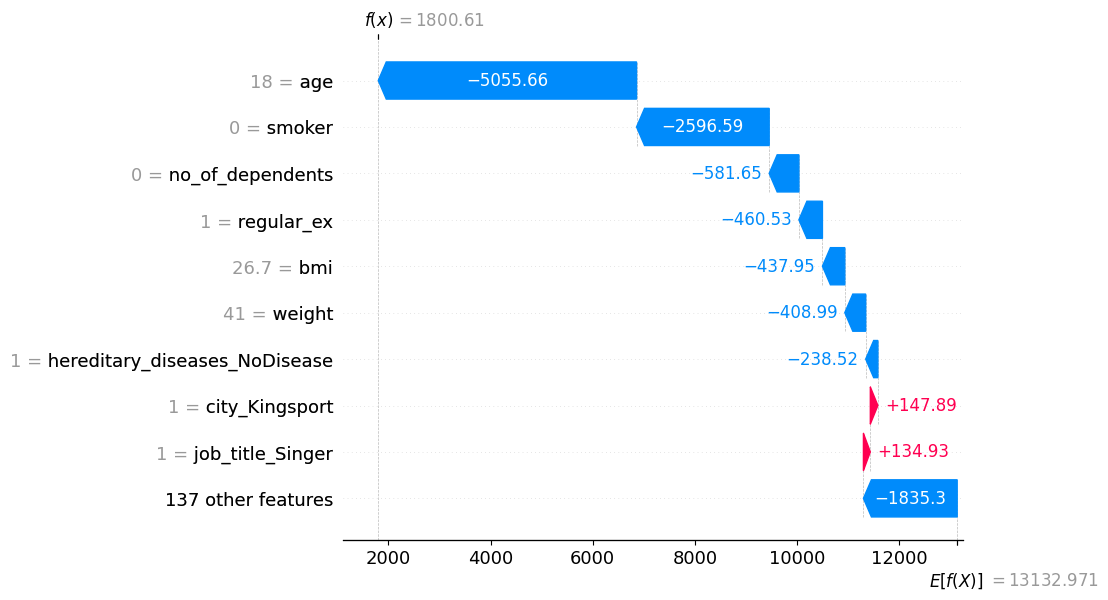

In [17]:
#display all feature contribution in a waterfall plot
#print(X.iloc[0])
#print(explanation)
shap.waterfall_plot(explanation)
#print the prediction that shap stored








In [18]:
#Partial Dependence Plot
import matplotlib.pyplot as plt

#create function to get all values for a a column
def get_column_values(column, X):
    return X[column].values

#function that gets all rows with a certain value for a certain column
def get_rows_with_value(column, value, X):
    return X[X[column] == value]

#function takes in a set of rows and then returns the average of the prediction
def get_average_prediction(rows):
    predictions = []
    for i in range(len(rows)):
        row = rows.iloc[i]
        row = scaler.transform([row])
        row = torch.tensor(row, dtype=torch.float32)
        prediction = model(row).item()
        predictions.append(prediction)
    return np.mean(predictions)

#function that returns a 2d array of value-average prediction pairs
def get_value_prediction_pairs(column, X):
    values = get_column_values(column, X)
    value_prediction_pairs = []
    for value in values:
        rows = get_rows_with_value(column, value, X)
        average_prediction = get_average_prediction(rows)
        value_prediction_pairs.append([value, average_prediction])
    return value_prediction_pairs

#plot the value prediction pairs
def plot_value_prediction_pairs(column, X):
    value_prediction_pairs = get_value_prediction_pairs(column, X)
    # Sorting the pairs to make the plot more coherent, especially if the values are numeric
    value_prediction_pairs.sort(key=lambda x: x[0])
    
    values = [pair[0] for pair in value_prediction_pairs]
    predictions = [pair[1] for pair in value_prediction_pairs]
    
    plt.figure(figsize=(10, 6))  # Set the figure size for better readability
    plt.plot(values, predictions, marker='o', linestyle='-', color='b')  # Plot with markers and a line
    plt.title(f'Partial Dependence Plot for {column}')  # Set title
    plt.xlabel(column)  # Set x-axis label
    plt.ylabel('Average Prediction')  # Set y-axis label
    plt.grid(True)  # Enable grid for easier readability
    plt.show()  # Display the plot











In [19]:
X_train_pandas_pdp = X_train_pandas
X_train_pandas_pdp.head()

#create a list of the average in very column
average_per_column = []
for column in X_train_pandas_pdp.columns:
    average = X_train_pandas_pdp[column].mean()
    average_per_column.append(average)
#print(average_per_column)

#get rid of the first entry
average_per_column = average_per_column
#print(feature_names[1:])
#transform back to pandas


non_explorable_columns = pd.DataFrame(X_train_pandas_pdp, columns=feature_names)
non_explorable_columns = non_explorable_columns.drop('age', axis=1) 
#display
non_explorable_columns.head()


#get unique age values
age_values = X_train_pandas_pdp['age'].unique()



age_values = pd.DataFrame(age_values, columns=['age'])

age_values.head()

#add age_values to non_explorable_columns
X_train_pandas_pdp = pd.concat([age_values, non_explorable_columns], axis=1)




In [20]:
#Partial Dependence Plot
import matplotlib.pyplot as partial_dependence
X_train_pandas_pdp = X_train_pandas

#sort pandas data set according to a column, lowest at first
X_train_pandas_pdp = X_train_pandas_pdp.sort_values(by='age', ascending=True)

# Get the unique values in the 'age' column
non_age_columns = X_train_pandas_pdp.drop(columns=['age'])
# Get the average of the non-'age' columns
non_age_avg = non_age_columns.mean()

X_train_pandas_pdp['age'] = X_train_pandas_pdp['age'].fillna(non_age_avg)

# Fill missing values in the 'age' column with the average row values
X_train_pandas_pdp['age'] = X_train_pandas_pdp['age'].fillna(non_age_avg)
X_train_pandas_pdp.head(100)
#Group the data by the column
grouped_data = X_train_pandas_pdp.groupby('age')
#print thd groups
#for name, group in grouped_data:
    #print(name)
    #print(group)

#Scale each group
scaled_data = []
for name, group in grouped_data:
    group = scaler.transform(group)
    scaled_data.append(group)

#convert the list to a list of tensors
scaled_data = [torch.tensor(group, dtype=torch.float32) for group in scaled_data]

#calculate the average prediction for each group
average_predictions = []
for group in scaled_data:
    predictions = []
    for i in range(len(group)):
        row = group[i]
        row = torch.tensor(row, dtype=torch.float32)
        prediction = model(row).item()
        predictions.append(prediction)
    average_predictions.append(np.mean(predictions))


#plot the partial dependence plot
partial_dependence.plot(values, average_predictions)
partial_dependence.title('Partial Dependence Plot for age')
partial_dependence.xlabel('age')
partial_dependence.ylabel('Average Claim')
partial_dependence.grid(True)
partial_dependence.show()


C:\Users\kobra\AppData\Local\Temp\ipykernel_37592\1366468535.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  row = torch.tensor(row, dtype=torch.float32)


NameError: name 'values' is not defined